## In previous code have created dataset and stored in S3. We will download this dataset, preprocess it and perform transfer learning using ResNet model.
## This base model will be tested and validated with test images.

## We shall then save this model back to S3 and use it different code, where app will be deployed using FastAPI will and ngrok will

## Loading Credentials from Collab Env

In [34]:
#Access your secret keys in Python via:
from google.colab import userdata

BUCKET_NAME =userdata.get('cvBucket')
ACCESS_KEY= userdata.get('accessKey')
SECRET_KEY= userdata.get('secretKey')

In [35]:
!pip install boto3 -q

In [4]:
import boto3

# Object to access S3 resources.
s3 = boto3.resource('s3', aws_access_key_id = ACCESS_KEY, aws_secret_access_key= SECRET_KEY)



## Looking out for all avialable dataset within that bucket

In [36]:
# List the files in the specified S3 bucket
def list_files_in_bucket(bucket_name):
    bucket = s3.Bucket(bucket_name)

    for obj in bucket.objects.all():
        print(obj.key)

# Call the function to list files
list_files_in_bucket(BUCKET_NAME)


Test_Raw_images.zip
dataset.pkl
face_detector.h5
raw_image_files.zip
test_dataset.pkl


In [37]:
#dataset.pkl is the file we should download

import botocore
# save the filename in KEY variable
KEY = 'dataset.pkl' # replace with your object key

try:
  # we are trying to download file from s3 with name `raw_image_files.zip` stored in varaible KEY
  # to colab dir with name `raw_image_files.zip`
  s3.Bucket(BUCKET_NAME).download_file(KEY, 'dataset.pkl')

except botocore.exceptions.ClientError as e:
  if e.response['Error']['Code'] == "404":
    print("The object does not exist.")
  else:
    raise

In [38]:
## Un-pickle
import pickle
with open('/content/dataset.pkl', 'rb') as f:
    df = pickle.load(f)

## Preprocessing

In [39]:
import pandas as pd
import cv2
import numpy as np

In [40]:
df.head()

,file_path,normalized_image,label
0,/content/dataset/acceptable/human face without...,"[[[0.2901960784313726, 0.3215686274509804, 0.3...",acceptable
1,/content/dataset/acceptable/human face without...,"[[[0.9882352941176471, 0.984313725490196, 0.98...",acceptable
2,/content/dataset/acceptable/human face without...,"[[[0.8235294117647058, 0.8156862745098039, 0.8...",acceptable
3,/content/dataset/acceptable/human face without...,"[[[0.8313725490196079, 0.8823529411764706, 0.9...",acceptable
4,/content/dataset/acceptable/human face without...,"[[[0.49411764705882355, 0.21176470588235294, 0...",acceptable


In [41]:
type(df['normalized_image'][0]),df['normalized_image'][0].shape

(numpy.ndarray, (224, 224, 3))

In [42]:
df.shape

(794, 3)

In [44]:
df['label'].value_counts()

label
alarming      574
acceptable    220
Name: count, dtype: int64

## We can see, the file_path col is not needed for training
## 2nd column has normalised values. We had dataset crearted with 224x224 per image size. and then normalise it
## Labels need to be converted into 0 and 1
## so here we will only be forming array of image data and corrosponding labels


In [45]:
# Define the mapping of folder names to labels
label_mapping = {'acceptable': 0, 'alarming': 1}
df['label_num'] =df['label'].map(label_mapping)

df.head(3)

,file_path,normalized_image,label,label_num
0,/content/dataset/acceptable/human face without...,"[[[0.2901960784313726, 0.3215686274509804, 0.3...",acceptable,0
1,/content/dataset/acceptable/human face without...,"[[[0.9882352941176471, 0.984313725490196, 0.98...",acceptable,0
2,/content/dataset/acceptable/human face without...,"[[[0.8235294117647058, 0.8156862745098039, 0.8...",acceptable,0


In [46]:
image_data =np.stack(df['normalized_image'])
labels = np.array(df['label_num'])
image_data.shape,labels.shape

((794, 224, 224, 3), (794,))

In [47]:
type(image_data),type(labels)

(numpy.ndarray, numpy.ndarray)

#Model Development with Transfer Learning (ResNet)

In [48]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [49]:
# Split the dataset into training and test sets
xtrain, xtest, ytrain, ytest = train_test_split(image_data, labels, test_size=0.2, random_state=7)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape


((635, 224, 224, 3), (159, 224, 224, 3), (635,), (159,))

In [50]:

# Load the ResNet50 model with pre-trained weights, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [51]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [52]:
# Freeze the base model layers

for layer in base_model.layers:
  layer.trainable = False

In [53]:
# Create a new model
model = Sequential()

# Add the base model as a layer
model.add(base_model)

# Add custom layers on top of the base model
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1605696   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16320449 (62.26 MB)
Trainable params: 1605761 (6.13 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [1]:
"""# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
"""

NameError: name 'base_model' is not defined

In [55]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint

#Chekpointer will save the weights that yeilds high accuracy with low loss
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1,
                               save_best_only=True)

# Train the model
history = model.fit(xtrain, ytrain,validation_data=(xtest, ytest), epochs=10, batch_size=32,callbacks=[checkpointer])


Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 0.7491 - accuracy: 0.7291
Epoch 1: val_loss improved from inf to 0.38353, saving model to model.weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 6s 256ms/step - loss: 0.7491 - accuracy: 0.7291 - val_loss: 0.3835 - val_accuracy: 0.8553
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.8425
Epoch 2: val_loss improved from 0.38353 to 0.32334, saving model to model.weights.best.hdf5
20/20 [==============================] - 4s 217ms/step - loss: 0.3500 - accuracy: 0.8425 - val_loss: 0.3233 - val_accuracy: 0.8679
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.2600 - accuracy: 0.8772
Epoch 3: val_loss did not improve from 0.32334
20/20 [==============================] - 4s 198ms/step - loss: 0.2600 - accuracy: 0.8772 - val_loss: 0.3243 - val_accuracy: 0.8742
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.8850
Epoch 4: val_loss improved from 0.32334 to 0.30939, saving model to model.weights.best.hdf5
20/20 [==============================] - 3s 178ms/step - loss: 0.2426 - accuracy: 0.8850 - val

## Visualising Training -Validation Accuracy and loss

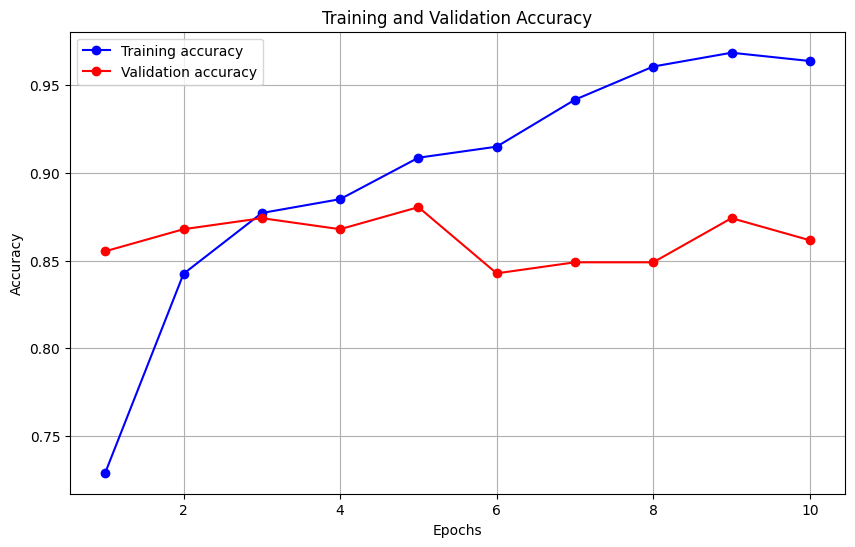

In [57]:
import matplotlib.pyplot as plt

# Extract accuracy and validation accuracy from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract the number of epochs
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


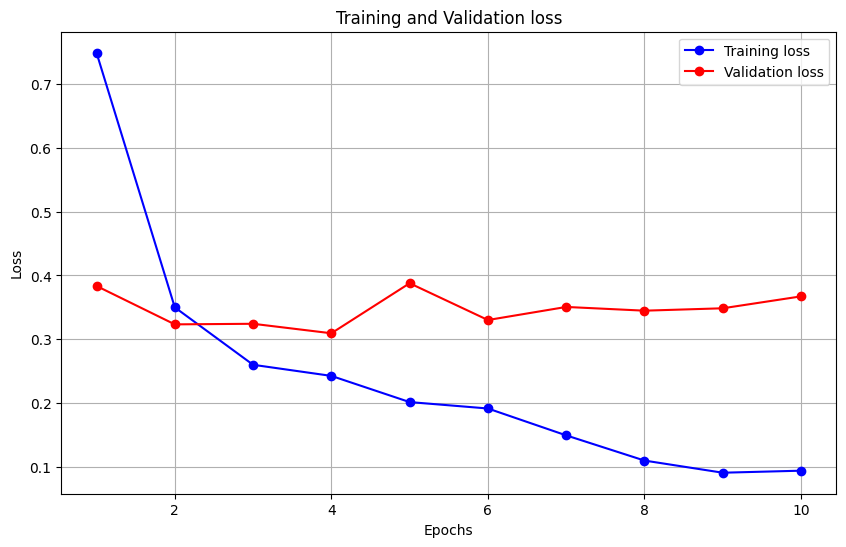

In [58]:
# Extract accuracy and validation accuracy from history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract the number of epochs
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## load the weights that yielded the best validation accuracy

In [59]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

In [60]:
# Save the trained model
model.save('face_detector.h5')

# Pushing the model to S3

In [61]:
## Pushing this model to AWS s3

#Creating S3 object that will  push this dataset
push_to_s3= boto3.client('s3',aws_access_key_id=ACCESS_KEY,aws_secret_access_key=SECRET_KEY)



#Using object pushing/ uploading image datset to S3
push_to_s3.upload_file('/content/face_detector.h5',BUCKET_NAME, 'face_detector.h5')